<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CosmicNeutrons/NeutronBackgroundEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_dzhadan')
import math


Mounted at /content/drive


In [2]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-tqvul9kz
  Running command git clone -q https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-tqvul9kz
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5995 sha256=38435d5333a20b0e57ee436e962e3b0be6f62b7a16e68ec64d79999045639dbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-caps_0td/wheels/00/92/a8/d2a2c55928a20d8675652a7135b8880f1f4f9b655d8885d452
Successfully built mu2etools


In [3]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [4]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Plot CRY4

In [5]:
try:
    dfCRY4
except NameError:
    dfCRY4 = pd.read_hdf(main_path + "root_files_dzhadan/cry4df.h5").query('(lyield==17000)')

In [6]:
dfCRY_all = pd.read_hdf(main_path + "root_files_dzhadan/cry4df.h5")

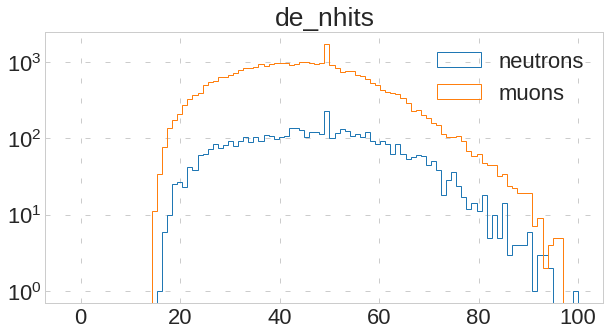

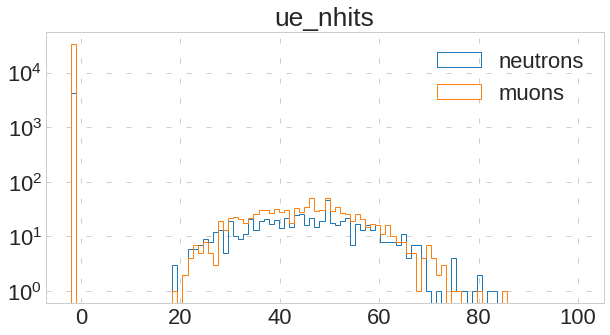

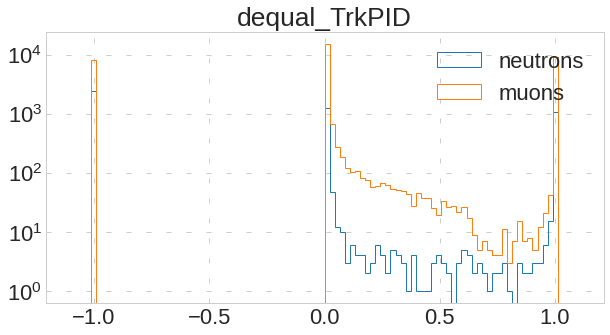

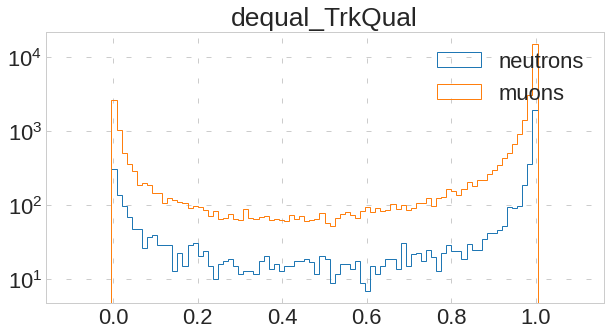

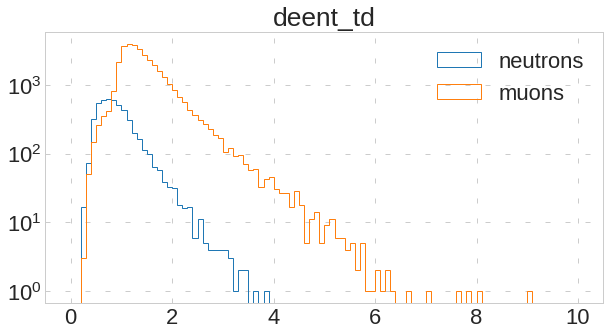

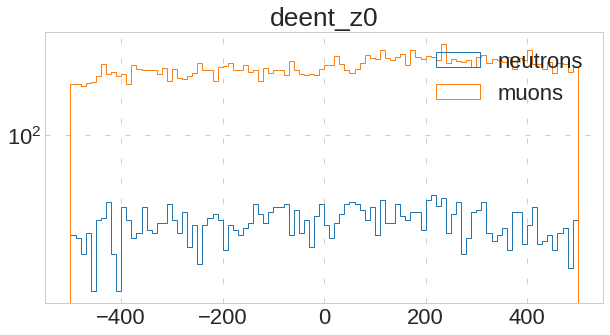

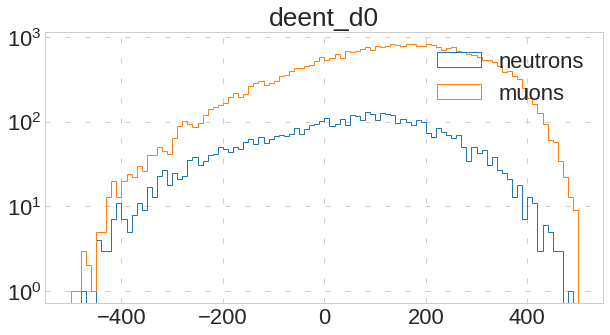

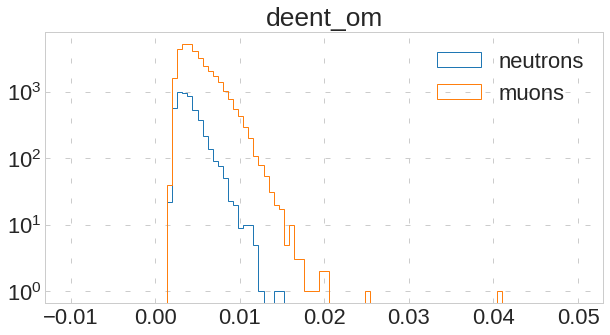

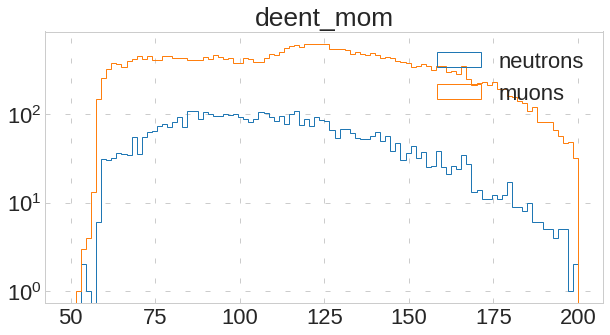

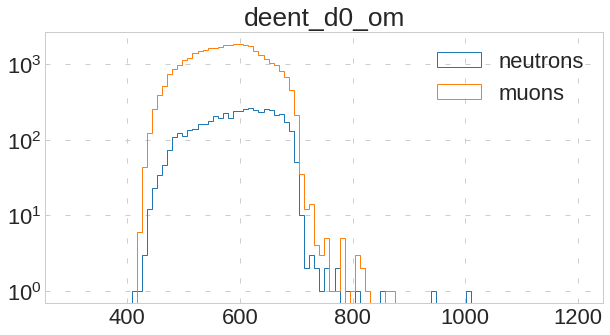

In [7]:
var_dict = utils.getVarList('all')

for var in var_dict.keys():
  if "crvinfo" in var: 
    continue
  plt.figure()
  plt.title(var)
  plt.hist(dfCRY4.query('demcgen_pdg==2112  & crvinfo__timeWindowStart<0')[var], bins=100, range=var_dict[var], histtype='step', label='neutrons');
  plt.hist(dfCRY4.query('abs(demcgen_pdg)==13 & crvinfo__timeWindowStart<0')[var], bins=100, range=var_dict[var], histtype='step', label='muons');
  plt.yscale('log')
  plt.legend()

In [8]:
var_dict

{'crvinfo__PEs': [-1, 1000],
 'crvinfo__dT': [-500, 500],
 'crvinfo__x': [-8000, 1000],
 'crvinfo__y': [0, 3500],
 'crvinfo__z': [-5000, 20000],
 'de_nhits': [-2, 100],
 'deent_d0': [-500, 500],
 'deent_d0_om': [300, 1200],
 'deent_mom': [50, 200],
 'deent_om': [-0.01, 0.05],
 'deent_td': [0, 10],
 'deent_z0': [-500, 500],
 'dequal_TrkPID': [-1.1, 1.1],
 'dequal_TrkQual': [-0.1, 1.1],
 'ue_nhits': [-2, 100]}

In [9]:
ndf = dfCRY4.query('abs(demcgen_pdg)==13 & crvinfo__timeWindowStart<0')
for label in dfCRY4.query('abs(demcgen_pdg)==13 & crvinfo__timeWindowStart<0').columns:
    if label not in var_dict or "crvinfo" in label:
        ndf = ndf.drop(columns=label)
muon_df = ndf

In [10]:
ndf = dfCRY4.query('demcgen_pdg==2112 & crvinfo__timeWindowStart<0')
for label in dfCRY4.query('demcgen_pdg==2112 & crvinfo__timeWindowStart<0').columns:
    if label not in var_dict or "crvinfo" in label:
        ndf = ndf.drop(columns=label)
neutron_df = ndf

In [11]:
neutron_data = neutron_df.to_numpy()
#muon_data = np.take(muon_df.to_numpy(), np.random.choice(len(muon_df), len(neutron_df)), axis=0)
muon_data = muon_df.to_numpy()
 

In [12]:
Y_data = np.append(np.zeros(len(muon_data),dtype=int),np.ones(len(neutron_data), dtype=int))  # 0 - muon, 1 - neutron
X_data = np.append(muon_data, neutron_data, axis = 0)
AData = np.append(X_data,Y_data.reshape(len(muon_data) + len(neutron_data), 1), axis = 1)
np.random.shuffle(AData)
X_data, Y_data = AData[:,:-1], AData[:,10]
Y_data = np.array([int(x) for x in Y_data])

In [13]:
n_v = int(len(X_data) * 0.2)
n_tr = len(X_data) - n_v

In [14]:
from sklearn import svm, metrics

In [15]:
def get_my_data(num_training=n_tr, num_validation=n_v, num_test=0):

    X_train, y_train = X_data, Y_data
        
    # Сэмплируем из полного набора данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    return X_train, y_train, X_val, y_val


# Вызываем функцию чтобы получить данные.
X_train, y_train, X_val, y_val = get_my_data()
print('Train data shape: ', X_train.shape)
print('Train label shape: ', y_train.shape)
print('Val data shape: ', X_val.shape)
print('Val label shape:  ', y_val.shape)

Train data shape:  (31964, 10)
Train label shape:  (31964,)
Val data shape:  (7990, 10)
Val label shape:   (7990,)


In [16]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [17]:
proba = clf.predict_proba(X_val)
y_score = [ x[1] for x in proba]
fpr, tpr, thresholds = metrics.roc_curve(y_val.flatten(), y_score)

In [18]:
fpr1, tpr1, thresholds1 = fpr, tpr, thresholds

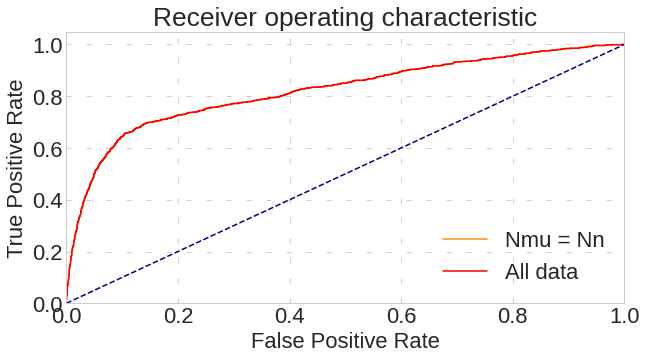

In [19]:
plt.figure()
plt.plot(fpr1, tpr1, color="darkorange", label="Nmu = Nn")
plt.plot(fpr, tpr, color="red", label="All data")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [20]:
neve_extmom = len(dfCRY4.query(cuts.cut_extmom))
neve_physmom = len(dfCRY4.query(cuts.cut_phymom))
mom_scale = neve_extmom/neve_physmom
print('Momentum scale: %2.1f'% mom_scale)
ave, err, _, _, _, _ = utils.getNormBackground(dfCRY4, 'abs(demcgen_pdg)==13', mom_scale)
print('Muon background: %2.3f +/- %2.3f'%(ave*1.2, err*np.sqrt(1.2)))

ave, err, _, _, _, _ = utils.getNormBackground(dfCRY4, 'demcgen_pdg==2112', mom_scale)
print('Neutron background: %2.3f +/- %2.3f'%(ave*1.2, err*np.sqrt(1.2)))

Momentum scale: 34.8
Muon background: 13409.987 +/- 14.855
Neutron background: 6.761 +/- 0.254


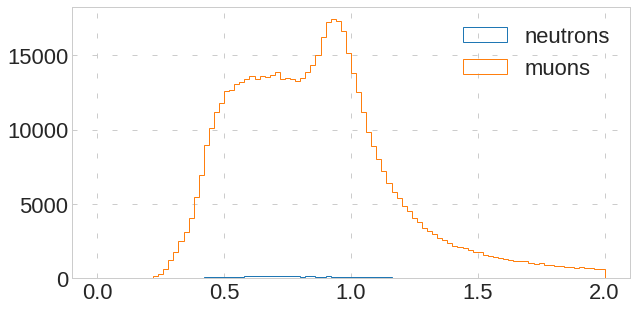

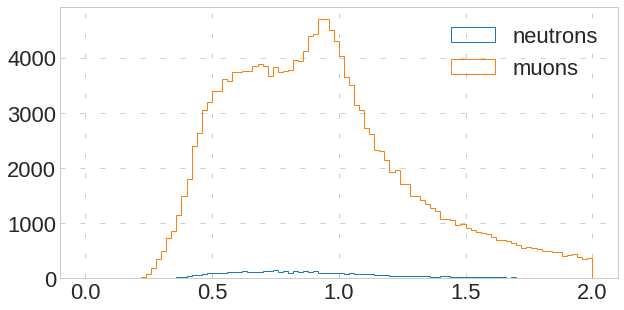

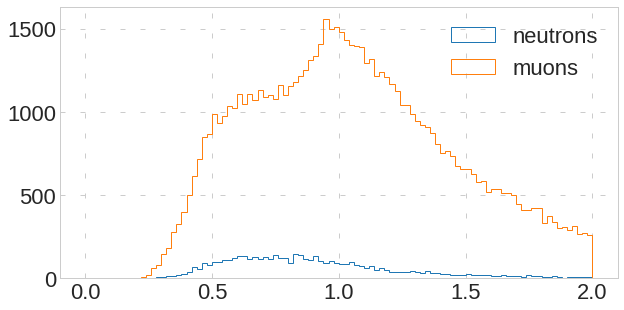

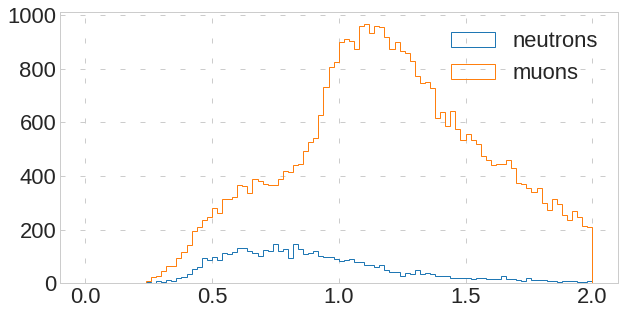

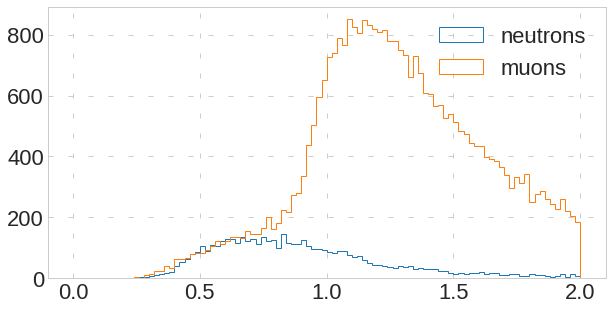

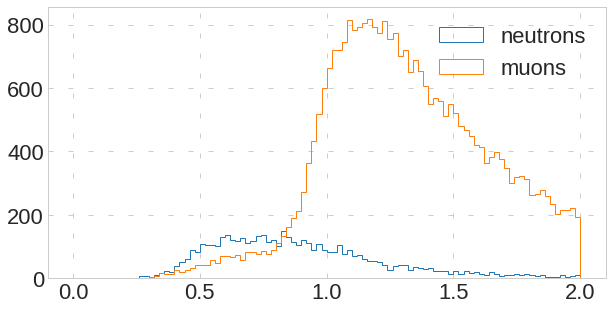

In [41]:
  for ly in range(7000, 17001, 2000):

    plt.figure()
    plt.hist(dfCRY_all.query('demcgen_pdg==2112  & crvinfo__timeWindowStart<0 & lyield==%d'%ly)[ 'deent_td'], bins=100, range=(0,2.0), histtype='step', label='neutrons');
    plt.hist(dfCRY_all.query('abs(demcgen_pdg)==13 & crvinfo__timeWindowStart<0 & lyield==%d'%ly)['deent_td'], bins=100, range=(0,2.0), histtype='step', label='muons');
    plt.legend()

In [39]:
for ly in range(7000, 17001, 2000):
  print(ly)
  for pa in np.arange(0.2, 1.5, 0.1):
    try:
        nback = utils.getNormBackground(dfCRY_all,'demcgen_pdg==2112 & crvinfo__timeWindowStart<0 & lyield==%d & deent_td < %f' % (ly, pa) ,1)[0]
        mback = utils.getNormBackground(dfCRY_all,'abs(demcgen_pdg)==13 & crvinfo__timeWindowStart<0 & lyield==%d & deent_td < %f' % (ly, pa),1)[0]
        print('%f \t %f' % (pa, nback / math.sqrt(mback)))
    except:
        print('\t division by zero : %f' % pa)

7000
0.200000 	 0.000000
0.300000 	 0.029606
0.400000 	 0.114226
0.500000 	 0.179067
0.600000 	 0.267887
0.700000 	 0.366523
0.800000 	 0.432697
0.900000 	 0.501977
1.000000 	 0.544260
1.100000 	 0.567898
1.200000 	 0.586942
1.300000 	 0.595724
1.400000 	 0.607328
9000
0.200000 	 0.000000
0.300000 	 0.054469
0.400000 	 0.216283
0.500000 	 0.448610
0.600000 	 0.602864
0.700000 	 0.763552
0.800000 	 0.900864
0.900000 	 1.035572
1.000000 	 1.094192
1.100000 	 1.138291
1.200000 	 1.166968
1.300000 	 1.176663
1.400000 	 1.197905
11000
	 division by zero : 0.200000
0.300000 	 0.091401
0.400000 	 0.436567
0.500000 	 0.735442
0.600000 	 1.080674
0.700000 	 1.457526
0.800000 	 1.719115
0.900000 	 1.952559
1.000000 	 2.079414
1.100000 	 2.131364
1.200000 	 2.140713
1.300000 	 2.125712
1.400000 	 2.139558
13000
	 division by zero : 0.200000
0.300000 	 0.195389
0.400000 	 0.649648
0.500000 	 1.536120
0.600000 	 2.202634
0.700000 	 2.862678
0.800000 	 3.370271
0.900000 	 3.731398
1.000000 	 3.77846